#How to make a tailored TED talk? 

#### Date:  06/01/2015

This notebook is based on Ted_4_Feature testing, feature engineering/selections are done in other notebooks such as Ted_2 (caption) and Ted_5 (other textual data); the raw data is processed in Ted_1. The splitting of training set and final holdout dataset is done in Ted_3

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
%matplotlib inline
import requests
from pattern import web
import operator

In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier

In [31]:
from sklearn.pipeline import Pipeline
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import StratifiedKFold
from sklearn.grid_search import GridSearchCV

In [32]:
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.preprocessing import label_binarize
from unidecode import unidecode
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import SVC
from sklearn.base import BaseEstimator,TransformerMixin

In [33]:
from nltk import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import pos_tag

##1. Process themes into vector

In [34]:
talks_small = pd.read_json('train2.json')

In [35]:
talks_small.reset_index(drop = True, inplace = True)

In [38]:
# to hide
talks_small.shape

(1535, 33)

In [39]:
# convert the theme dictionary to list of themes
def themes_fun(row):
    # convert the original themes (dict) to list
    themes = []
    for theme in row['themes']:
        themes.append(theme['theme']['name'])
    return themes

In [40]:
themes = []
for i in xrange(talks_small.shape[0]):
    themes.append(themes_fun(talks_small.ix[i,:]))

In [47]:
# get the total themes, used as vocabulary
th_url = 'https://api.ted.com/v1/themes.json?api-key=ynw2u8e4h9sk8c2htp7vutxq&limit=100'
th_res = requests.get(th_url)

In [48]:
vocab_theme = [(x['theme']['name'],x['theme']['id']) for x in th_res.json()['themes']]

In [49]:
vocab_theme = dict(vocab_theme)

In [50]:
vocab_theme = vocab_theme.keys()

In [13]:
vocab_theme = [u'Live Music',u'Celebrating TEDWomen',u'Whipsmart Comedy',u'Listening to Teachers',u'Spectacular Performance',
 u'Ocean Wonders',u'Bold Predictions, Stern Warnings',u'What Makes Us Happy?',u'Media With Meaning',u'Technology, History and Destiny',
 u'How the Mind Works',u'Talks from TED Fellows',u'Medicine Without Borders',u'Hidden Gems',u'War and Peace',
 u'The Rise of Collaboration',u'TED Prize Winners',u"Evolution's Genius",u'Unconventional Explanations',u"What's Next in Tech",
 u'Presentation Innovation',u'Words About Words',u'Numbers at Play',u'Women Reshaping the World',u'Art Unusual',
 u'Not Business as Usual',u'To Boldly Go ...',u'Architectural Inspiration',u'Africa: The Next Chapter',u'TED in 3 Minutes',
 u'Tales of Invention',u'Inspired by Nature',u'Is There a God?',u'Design That Matters',u'Food Matters',u'How We Learn',u'Master Storytellers',
 u'Animals That Amaze',u'The Power of Cities',u'A Greener Future?',u'The Creative Spark',u'Peering into Space',u'Best of the Web',
 u'Rethinking Poverty',u'The Charter for Compassion',u'Might You Live a Great Deal Longer?',u'Mission Blue Voyage']

In [51]:
vocab_theme[1]

u'Celebrating TEDWomen'

In [52]:
talks_small['themes'] = themes

In [53]:
talks_small['themes'] = talks_small['themes'].apply(lambda x: ' '.join(x))

#### The maximum length of all themes is 35 grams, therefore use ngram_range = (2,40)

In [54]:
# shortest themes are of 2 words, longest 7words
Cvtheme = CountVectorizer(vocabulary=vocab_theme,binary = True, analyzer='char',ngram_range=(2,40),lowercase = False)

##2. Convert onespeaker feature into integer 

In [55]:
talks_small['onespeaker'] = (talks_small['onespeaker']==True).astype(int)

##3. Process the label 

In [56]:
labels = pd.read_csv('response5.csv',header =None )

In [57]:
labels.columns = ['id','label']

In [58]:
counts = labels.groupby('label')['label'].count()

In [59]:
fractions = counts/counts.sum()

In [60]:
fractions.index = ['persuasive informative','beautiful courageous inspiring','jaw-dropping ingenious fascinating',
                  'ok obnoxious confusing unconvincing long-winded', 'funny']

In [61]:
fractions

persuasive informative                             0.308795
beautiful courageous inspiring                     0.272313
jaw-dropping ingenious fascinating                 0.229967
ok obnoxious confusing unconvincing long-winded    0.116612
funny                                              0.072313
Name: label, dtype: float64

#### Make a plot of label distribution in the training set

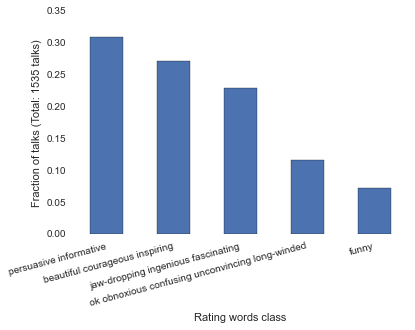

In [62]:
fractions.plot(kind = 'bar')
plt.xticks(rotation = 15, ha = 'right')
plt.ylabel('Fraction of talks (Total: 1535 talks)')
plt.xlabel('Rating words class')

##4. Construct final training set Xdf and y, which is the label 

###4.1 Features from talks_small are id, theme and speaker_gender

In [65]:
Xdf = talks_small[['id','themes','speaker_gender']]

In [66]:
Xdf = Xdf.sort(columns = 'id')

###4.2 Features from captions, processed in Ted_2 

In [67]:
caps = pd.read_json('captions_f.json')[['id','length','num_para','word_per_sec','laughter_per_word','laugh_as_para',
                                     'applause_total','div_per_word','ithinks','storywords','noun_token','verb_token']]

In [68]:
caps = caps.sort(columns = 'id')

In [69]:
caps.reset_index(inplace = True, drop = True)

### 4.3 Features from other text source (title + keywords + description), generated in Ted_5

In [70]:
Xother = pd.read_json('talks_other_text.json')

In [71]:
Xother.sort(columns = 'id',inplace = True)

In [72]:
Xother.reset_index(inplace = True, drop = True)

###4.4 Merge all three sources into Xdf 

In [73]:
Xdf = pd.merge(Xdf,caps,on = 'id')

In [74]:
Xdf = pd.merge(Xdf,Xother, on = 'id')

In [75]:
Xdf.sort(columns = 'id',inplace = True)

###4.5 Generate y from labels 

In [76]:
labels.sort(columns = 'id',inplace = True)

In [77]:
labels.reset_index(drop = True, inplace = True)

In [78]:
y = labels[['label']].values.flatten()

## 5 Learning

### 5.1 a single test-train split 

In [79]:
sss = StratifiedShuffleSplit(y, n_iter = 1, test_size=0.2, random_state=1)

In [80]:
for train_index,test_index in sss:
    Xdftrain,Xdftest = Xdf.ix[train_index,:],Xdf.ix[test_index,:]
    ytrain,ytest = y[train_index],y[test_index]

####5.1.1 Convert the text(title +kw + description) into a matrix using CountVectorizer

In [81]:
Xtrain_text = Xdftrain['text'].as_matrix()

In [82]:
Xtest_text = Xdftest['text'].as_matrix()

##### the following list is derived in Ted_5_NLP_other 

In [83]:
final_text_words = ['global issues', 'science', 'culture', 'new','humor','entertainment']

In [84]:
vect_other = CountVectorizer(vocabulary = final_text_words, stop_words = 'english', ngram_range = (1,2))

In [85]:
Xtrain_text_other = vect_other.fit_transform(Xtrain_text)

In [86]:
Xtest_text_other = vect_other.transform(Xtest_text)

#### 5.1.2 Convert themes into a matrix using Cvtheme (a CountVectorizer) defined previously

In [87]:
Xtrain_th = Cvtheme.fit_transform(Xdftrain.ix[:,'themes'].as_matrix())

In [88]:
Xtest_th = Cvtheme.transform(Xdftest.ix[:,'themes'].as_matrix())

#### 5.1.3 Convert verb and noun tokens in the caption to a matrix using TfidfVectorizer

##### the vocabulary lists are derived in Ted_2_NLP_caption 

Both noun and verb vocabulary are selected by the following procedure:
    1. tokens that have log probability larger than -3 are filtered out
    2. tokens must appear in more than 60% of talks in the selected class
    3. vocabulary of each class are combined to form the ultimate noun or verb vocabulary

In [293]:
vocab_verb_final = [u'like',u'show',u'feel',u'should',u'leave',u'live',u'understand',u'talk',u'ask',u'become',u'change']

In [342]:
vocab_noun_final = [u'life',u'percent',u'question',u'story',u'idea',u'part',u'place',u'fact',u'example',u'problem',u'bit',u'kind',u'today']

In [476]:
tf_noun = TfidfVectorizer(vocabulary = vocab_noun_final,use_idf = False, sublinear_tf = True)

In [477]:
tf_verb = TfidfVectorizer(vocabulary = vocab_verb_final,use_idf = False, sublinear_tf = True)

In [478]:
Xtrain_noun = tf_noun.fit_transform(Xdftrain.ix[:,'noun_token'].as_matrix())

In [479]:
Xtest_noun = tf_noun.transform(Xdftest.ix[:,'noun_token'].as_matrix())

In [483]:
Xtrain_verb = tf_verb.fit_transform(Xdftrain.ix[:,'verb_token'].as_matrix())

In [484]:
Xtest_verb = tf_verb.transform(Xdftest.ix[:,'verb_token'].as_matrix())

#### 5.1.4 Combine all features into Xtrain, Xtest

In [485]:
Xtrain = np.concatenate([Xtrain_th.toarray(),Xtrain_noun.toarray(),Xtrain_verb.toarray(),
                          Xtrain_text_other.toarray(), scale(Xdftrain.ix[:,2:12].as_matrix())],
                         axis = 1)

In [486]:
Xtest = np.concatenate([Xtest_th.toarray(),Xtest_noun.toarray(),Xtest_verb.toarray(),
                         Xtest_text_other.toarray(), scale(Xdftest.ix[:,2:12].as_matrix())],axis = 1)

#### 5.1.5 Test logistic regression and random forest 

#### Logistic Regresion

##### to improve the negative class prediction, class_weight can be specified to 'auto'

In [487]:
clf = LogisticRegression(C = 10, penalty = 'l2',class_weight = 'auto')

In [488]:
clf.fit(Xtrain,ytrain)

LogisticRegression(C=10, class_weight='auto', dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0)

In [489]:
ytest_pred = clf.predict(Xtest)

In [490]:
print classification_report(ytest,ytest_pred)

             precision    recall  f1-score   support

          0       0.64      0.66      0.65        95
          1       0.67      0.64      0.65        84
          2       0.56      0.55      0.55        71
          3       0.35      0.25      0.29        36
          4       0.52      0.77      0.62        22

avg / total       0.59      0.59      0.59       308



####Confusion matrix of the prediction 

In [491]:
pd.crosstab(ytest_pred,ytest,rownames=['Predicted'],colnames = ['True label'],margins = True)

True label,0,1,2,3,4,All
Predicted,,,,,,
0,63,13,12,9,1,98
1,8,54,8,9,2,81
2,15,8,39,7,1,70
3,6,2,8,9,1,26
4,3,7,4,2,17,33
All,95,84,71,36,22,308


#### list of feature names

In [492]:
other_vocab = sorted(vect_other.vocabulary_.items(), key = operator.itemgetter(1))

In [493]:
other_vocab = [x[0] for x in other_vocab]

In [494]:
noun_vocab = sorted(tf_noun.vocabulary_.items(), key = operator.itemgetter(1))

In [495]:
noun_vocab = [x[0] for x in noun_vocab]

In [496]:
verb_vocab = sorted(tf_verb.vocabulary_.items(), key = operator.itemgetter(1))

In [497]:
verb_vocab = [x[0] for x in verb_vocab]

In [498]:
feature_names = list(vocab_theme) + noun_vocab + verb_vocab + other_vocab + list(Xdftrain.columns[2:12])

###5.2 Use cross-validation on the whole training set to optimize hyperparameters 

In [499]:
Xth = Xdf['themes'].as_matrix()

In [500]:
Xth = Cvtheme.fit_transform(Xth)

In [501]:
Xtext_other = vect_other.transform(Xdf['text'].as_matrix())

In [502]:
X_noun = tf_noun.fit_transform(Xdf['noun_token'].as_matrix())

In [503]:
X_verb = tf_verb.fit_transform(Xdf['verb_token'].as_matrix())

In [504]:
X = np.concatenate([Xth.toarray(),X_noun.toarray(), X_verb.toarray(),
                    Xtext_other.toarray(),scale(Xdf.ix[:,2:12].as_matrix())],axis = 1)

#### Grid search to optimize hyper-parameters for Logistic Regression

In [505]:
param_logit = {'C':np.logspace(-2,2,20)}

In [506]:
clf2 = LogisticRegression(class_weight = 'auto',solver = 'lbfgs')

In [507]:
gs_logit = GridSearchCV(clf2, param_grid = param_logit, cv = StratifiedKFold(y,n_folds = 5), scoring = 'f1_micro')

In [508]:
gs_logit.fit(X,y)

GridSearchCV(cv=sklearn.cross_validation.StratifiedKFold(labels=[4 1 ..., 1 2], n_folds=5, shuffle=False, random_state=None),
       error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight='auto', dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=None, solver='lbfgs', tol=0.0001,
          verbose=0),
       fit_params={}, iid=True, loss_func=None, n_jobs=1,
       param_grid={'C': array([  1.00000e-02,   1.62378e-02,   2.63665e-02,   4.28133e-02,
         6.95193e-02,   1.12884e-01,   1.83298e-01,   2.97635e-01,
         4.83293e-01,   7.84760e-01,   1.27427e+00,   2.06914e+00,
         3.35982e+00,   5.45559e+00,   8.85867e+00,   1.43845e+01,
         2.33572e+01,   3.79269e+01,   6.15848e+01,   1.00000e+02])},
       pre_dispatch='2*n_jobs', refit=True, score_func=None,
       scoring='f1_micro', verbose=0)

In [509]:
print 'Best parameters set:'
best_parameters = gs_logit.best_estimator_.get_params()
for param_name in sorted(param_logit.keys()):
    print '\t%s: %r' % (param_name,best_parameters[param_name])

Best parameters set:
	C: 0.29763514416313175


#### The optimized logistic regression model 

In [510]:
logit = gs_logit.best_estimator_

#### Random Forest to estimate the overall feature importance

In [511]:
rf = RandomForestClassifier(n_estimators= 300, criterion='gini',class_weight = 'auto',oob_score=True)

In [512]:
rf.fit(X,y)

RandomForestClassifier(bootstrap=True, class_weight='auto', criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

In [513]:
rf.oob_score_

0.539413680781759

In [514]:
feature_importance = pd.Series(rf.feature_importances_,index = feature_names)

In [515]:
feature_importance.sort()

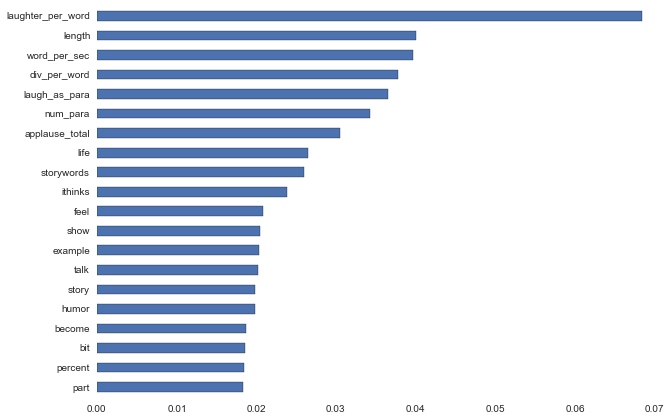

In [516]:
figure = plt.figure(figsize = (10,7))
feature_importance.ix[-20:].plot(kind = 'barh')

##6 How to make a ... talk

###6.1 Generate a dataframe of feature importance (importance_df) for each class 

In [517]:
X_unscaled = np.concatenate([Xth.toarray(),X_noun.toarray(), X_verb.toarray(),
                    Xtext_other.toarray(),Xdf.ix[:,2:12].as_matrix()],axis = 1)

In [518]:
Xdf_allf = pd.DataFrame(X_unscaled,columns=feature_names)

#####All unscaled features and label are stored in Xdf_allf 

In [519]:
Xdf_allf = pd.merge(Xdf_allf, labels, right_index = True,left_index = True)

In [520]:
importance_df = pd.DataFrame(logit.coef_,columns=feature_names)

In [521]:
importance_df.shape

(5, 87)

####Define a function to get the largest coefficients for each class 

In [197]:
def importantf(row_in_df, num):
    # row_in_df is one row in log_f_importance, can be part of the rows, e.g., row[:46] selects all themes
    # num of features to select
    row = row_in_df
    for ind in xrange(num):
        print 'top {} good feature is {} with coef: {}'.format(ind, row.idxmax(),row.max())
        row = row[row.index != row.idxmax()]

####Class 0: 

In [464]:
row_0 = importance_df.ix[0,:]

In [465]:
row_0.sort(ascending = False)

In [466]:
row_0[:20]

percent                             1.072294
Bold Predictions, Stern Warnings    0.943146
example                             0.877424
problem                             0.805544
Media With Meaning                  0.742005
Food Matters                        0.625080
question                            0.617779
Not Business as Usual               0.593631
should                              0.568581
fact                                0.545240
Technology, History and Destiny     0.513207
A Greener Future?                   0.483294
change                              0.411157
length                              0.403189
understand                          0.349992
How the Mind Works                  0.332199
culture                             0.284285
Unconventional Explanations         0.270494
The Rise of Collaboration           0.270275
How We Learn                        0.267514
Name: 0, dtype: float64

In [467]:
Xdf_allf.percent.describe()

count    1535.000000
mean        0.156693
std         0.182676
min         0.000000
25%         0.000000
50%         0.000000
75%         0.333333
max         1.000000
Name: percent, dtype: float64

In [168]:
row_1 = log_f_importance.ix[1,:]

In [169]:
row_1[row_1 > 0.5]

Live Music                             1.295153
Celebrating TEDWomen                   0.909718
Listening to Teachers                  1.282465
Medicine Without Borders               0.527761
War and Peace                          0.988621
TED Prize Winners                      1.570041
Women Reshaping the World              1.929600
To Boldly Go ...                       0.896098
Africa: The Next Chapter               0.521754
TED in 3 Minutes                       0.781964
How We Learn                           0.859438
Master Storytellers                    1.048829
The Creative Spark                     0.538504
Rethinking Poverty                     0.795518
Might You Live a Great Deal Longer?    1.081083
Mission Blue Voyage                    1.205458
life                                   1.824989
story                                  1.534571
place                                  0.588874
feel                                   2.625060
should                                 0

In [170]:
row2 = log_f_importance.ix[2,:]

In [171]:
row2[row2>0.5]

Spectacular Performance      0.957993
Ocean Wonders                0.760222
Evolution's Genius           0.993103
What's Next in Tech          0.705814
Numbers at Play              0.669411
To Boldly Go ...             0.870372
Architectural Inspiration    0.710931
Tales of Invention           0.770141
Inspired by Nature           1.080861
Is There a God?              1.338446
Design That Matters          0.573292
Peering into Space           0.615707
idea                         0.966517
part                         0.703939
bit                          0.761468
Name: 2, dtype: float64

In [172]:
row3 = log_f_importance.ix[3,:]

In [173]:
row3[row3>0.5]

Presentation Innovation      0.841774
Numbers at Play              0.763133
Architectural Inspiration    1.182889
The Power of Cities          0.560074
idea                         1.082670
fact                         0.545710
bit                          1.135201
kind                         0.822717
like                         0.853280
talk                         1.480584
become                       0.677501
entertainment                0.534688
Name: 3, dtype: float64

In [174]:
row4 = log_f_importance.ix[4,:]

In [175]:
row4[row4>0.5]

Live Music                     0.735648
Listening to Teachers          0.862977
Unconventional Explanations    0.794960
TED in 3 Minutes               0.601548
Design That Matters            1.090342
Animals That Amaze             2.195533
Rethinking Poverty             0.731601
fact                           1.464906
bit                            1.497121
today                          0.973389
like                           0.701526
show                           0.740128
ask                            1.023563
science                        0.655188
culture                        0.899096
humor                          3.442221
entertainment                  0.631777
word_per_sec                   0.609502
laughter_per_word              1.054663
laugh_as_para                  0.703283
Name: 4, dtype: float64

In [229]:
sum(Xdf_allf['Architectural Inspiration'] ==1)

43

(array([1, 2, 3, 4, 5]), <a list of 5 Text xticklabel objects>)

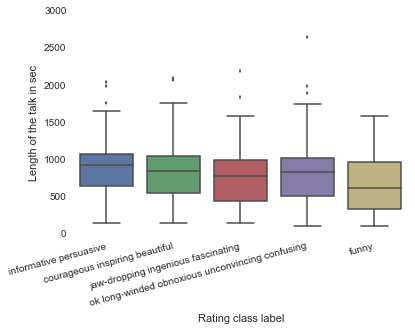

In [230]:
# length
ax0 = sns.boxplot(Xdf_allf.length,groupby=Xdf_allf.label)
plt.xlabel('Rating class label')
plt.ylabel('Length of the talk in sec')
ax0.set_xticklabels(['informative persuasive','courageous inspiring beautiful','jaw-dropping ingenious fascinating',
          'ok long-winded obnoxious unconvincing confusing','funny'])
plt.xticks(rotation = 15, ha = 'right')

(array([1, 2, 3, 4, 5]), <a list of 5 Text xticklabel objects>)

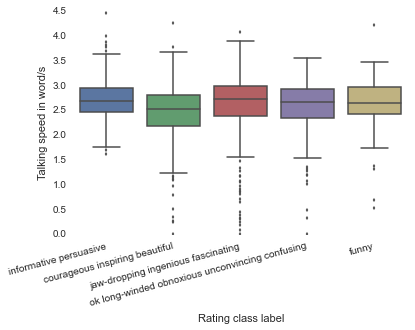

In [221]:
# talking speed
ax1 = sns.boxplot(Xdf_allf.word_per_sec, groupby = Xdf_allf.label)
plt.xlabel('Rating class label')
plt.ylabel('Talking speed in word/s')
ax1.set_xticklabels(['informative persuasive','courageous inspiring beautiful','jaw-dropping ingenious fascinating',
          'ok long-winded obnoxious unconvincing confusing','funny'])
plt.xticks(rotation = 15, ha = 'right')

(array([1, 2, 3, 4, 5]), <a list of 5 Text xticklabel objects>)

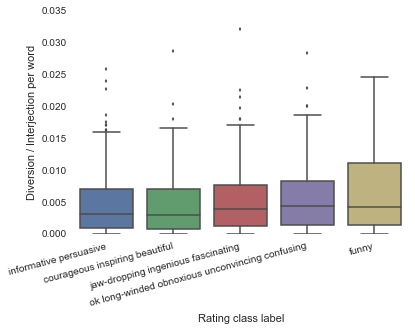

In [231]:
# diversion or interjection
ax4 = sns.boxplot(Xdf_allf.div_per_word,groupby = Xdf_allf.label)
plt.xlabel('Rating class label')
plt.ylabel('Diversion / Interjection per word')
ax4.set_xticklabels(['informative persuasive','courageous inspiring beautiful','jaw-dropping ingenious fascinating',
          'ok long-winded obnoxious unconvincing confusing','funny'])
plt.xticks(rotation = 15, ha = 'right')

(array([1, 2, 3, 4, 5]), <a list of 5 Text xticklabel objects>)

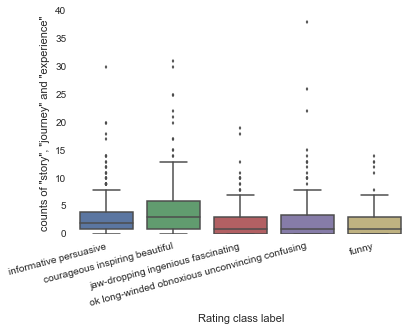

In [222]:
ax3 = sns.boxplot(Xdf_allf.storywords,groupby = Xdf_allf.label)
plt.xlabel('Rating class label')
plt.ylabel('counts of "story", "journey" and "experience"')
ax3.set_xticklabels(['informative persuasive','courageous inspiring beautiful','jaw-dropping ingenious fascinating',
          'ok long-winded obnoxious unconvincing confusing','funny'])
plt.xticks(rotation = 15, ha = 'right')